In [ ]:
import tensorflow
!nvidia-smi
#12.7 GB RAM
# 15.0 GB GPU
!python ‐‐version
!pip show keras
print(tensorflow.__version__)

Sun Feb 26 13:52:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

colab = True
name = "0090-GAN-0055"

if not colab: 
  train_dir = r'G:\Mi unidad\Uni\Cuarto curso\Primer cuatrimestre\TFG\WebScrapping\train'
  validation_dir = r'G:\Mi unidad\Uni\Cuarto curso\Primer cuatrimestre\TFG\WebScrapping\validation'
  test_dir = r'G:\Mi unidad\Uni\Cuarto curso\Primer cuatrimestre\TFG\WebScrapping\test'

else:
  train_dir = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/train'
  validation_dir = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/validation'
  test_dir = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/test'
  mini_test_dir = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/mini_test'

batch_size = 2
img_height = 1024 #1792
img_width = 768 #1280
img_gen = ImageDataGenerator()

train_gen = img_gen.flow_from_directory(train_dir,target_size=(img_height, img_width), 
                                         batch_size = batch_size, color_mode = "rgb", class_mode = "input")

validation_gen = img_gen.flow_from_directory(validation_dir,target_size=(img_height, img_width), 
                                         batch_size = batch_size, color_mode = "rgb", class_mode = "input")

test_gen = img_gen.flow_from_directory(test_dir,target_size=(img_height, img_width), 
                                         batch_size = batch_size, color_mode = "rgb", class_mode = "input")

mini_test_gen = img_gen.flow_from_directory(mini_test_dir,target_size=(img_height, img_width), 
                                         batch_size = 1, color_mode = "rgb", class_mode = "input", shuffle = False)

Found 1574 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 6 images belonging to 1 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.image import rgb_to_grayscale, grayscale_to_rgb
import tensorflow as tf

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def to_grayscale_then_rgb(image):
    image = rgb_to_grayscale(image)
    image = grayscale_to_rgb(image)
    return image

def preprocess(data):
    i = 0
    for imgs in data:
        img, label = imgs
        yield rgb2gray(img) / 255, label/ 255

(None, 1024, 768, 1) (None, 1024, 768, 3)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_gray (InputLayer)           [(None, 1024, 768,   0           []                               
                                1)]                                                               
                                                                                                  
 generator (Functional)         (None, 1024, 768, 3  54427267    ['in_gray[0][0]']                
                                )                                                                 
                                                                                                  
 model_2 (Functional)           (None, 64, 48, 1)    6966209     ['in_gray[0][0]',                
                                                  

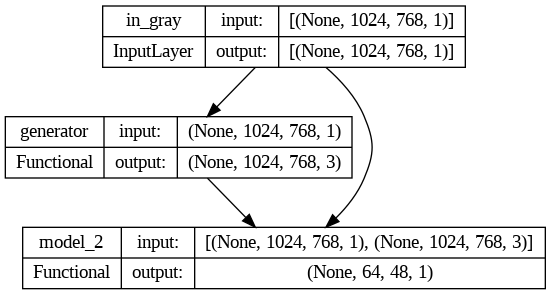

In [ ]:
# example of defining a composite model for training the generator model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define the discriminator model
def define_discriminator(gray_image_shape, RGB_image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02, seed = 123)
	# source image input
	in_src_image = Input(shape=gray_image_shape)
	# target image input
	in_target_image = Input(shape=RGB_image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02, seed = 1)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02, seed = 2)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02, seed = 5)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image, name="generator" )
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, gray_image_shape, RGB_image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# define the source image
	in_gray = Input(shape=gray_image_shape, name = "in_gray")
	in_RGB = Input(shape=RGB_image_shape, name = "in_RGB")
	print(in_gray.shape, in_RGB.shape)
	# connect the source image to the generator input
	gen_out = g_model(in_gray)
	
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_gray, gen_out])

	# src image as input, generated image and classification output
	model = Model(in_gray, [dis_out, gen_out])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,80])
	return model

# define image shape
gray_image_shape=(img_height,img_width,1)
RGB_image_shape=(img_height,img_width,3)
# define the models
d_model = define_discriminator(gray_image_shape, RGB_image_shape)
g_model = define_generator(gray_image_shape)
#d_model.summary()
#g_model.summary()
# define the composite model
gan_model = define_gan(g_model, d_model, gray_image_shape, RGB_image_shape)
# summarize the model
gan_model.summary()
# plot the model
plot_model(gan_model, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
n_steps = 8000
n_validation = 20
index = 0
history = {"d_loss1":[0.0]*(n_steps//n_validation),
	           "d_loss2":[0.0]*(n_steps//n_validation),
	           "g_loss":[0.0]*(n_steps//n_validation),
						 "val_d_loss1":[0.0]*(n_steps//n_validation),
						 "val_d_loss2":[0.0]*(n_steps//n_validation),
						 "val_g_loss":[0.0]*(n_steps//n_validation)	}

In [ ]:
import numpy as np
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	#trainA, trainB = dataset
	trainA, trainB = next(dataset)
	# choose random instances
	#ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA, trainB
	# generate 'real' class labels (1)
	y = np.ones((trainA.shape[0], patch_shape[0], patch_shape[1], 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape[0], patch_shape[1], 1))
	return X, y

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, validation_dataset, n_steps, n_validation, n_batch, n_patch, index):
	# unpack dataset
	#n_patch = (112,80)
	#trainA, trainB = dataset
	# calculate the number of batches per training epoch
	#bat_per_epo = int(len(trainA) / n_batch)
	bat_per_epo = 2000
	# calculate the number of training iterations
	
	print(index)
	history_d_loss1 = 0
	history_d_loss2 = 0
	history_g_loss = 0 

	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples


		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
	
		history_d_loss1 = history_d_loss1 + d_loss1
		history_d_loss2 = history_d_loss2 + d_loss2
		history_g_loss = history_g_loss + g_loss 

		# summarize performance
	
		
		if (i+1) % n_validation == 0  and i != 0:
			history["d_loss1"][index] = (history_d_loss1/n_validation)
			history["d_loss2"][index] = (history_d_loss2/n_validation)
			history["g_loss"][index] = (history_g_loss/n_validation)
	 
			history_d_loss1 = 0
			history_d_loss2 = 0
			history_g_loss = 0

			# select a batch of real samples
			[X_realA, X_realB], y_real = generate_real_samples(validation_dataset, n_batch, n_patch)
			# generate a batch of fake samples
			X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
			# update discriminator for real samples

			d_loss1 = d_model.evaluate([X_realA, X_realB], y_real)
			# update discriminator for generated samples
			d_loss2 = d_model.evaluate([X_realA, X_fakeB], y_fake)
			# update the generator
			g_loss, _, _ = gan_model.evaluate(X_realA, [y_real, X_realB])
			# summarize performance

			history["val_d_loss1"][index] = (d_loss1)
			history["val_d_loss2"][index] = (d_loss2)
			history["val_g_loss"][index] = (g_loss)
	 
			index = index + 1
			#print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
			print(index)

In [ ]:
train(d_model, g_model, gan_model, preprocess(train_gen), preprocess(validation_gen), n_batch = batch_size,n_steps = 500, n_validation = 20, n_patch = (64, 48), index = 0)

0
1/1 [==============================] - 1s 711ms/step - loss: 17.6008 - model_2_loss: 0.7010 - generator_loss: 0.2112
1
1/1 [==============================] - 0s 207ms/step - loss: 17.6166 - model_2_loss: 0.5581 - generator_loss: 0.2132
2
1/1 [==============================] - 0s 209ms/step - loss: 9.1366 - model_2_loss: 1.1254 - generator_loss: 0.1001
3
1/1 [==============================] - 0s 197ms/step - loss: 8.8051 - model_2_loss: 1.0550 - generator_loss: 0.0969
4
1/1 [==============================] - 0s 208ms/step - loss: 7.1629 - model_2_loss: 0.6907 - generator_loss: 0.0809
5
1/1 [==============================] - 0s 192ms/step - loss: 8.6252 - model_2_loss: 0.7118 - generator_loss: 0.0989
6
1/1 [==============================] - 0s 194ms/step - loss: 8.1918 - model_2_loss: 1.0721 - generator_loss: 0.0890
7
1/1 [==============================] - 0s 198ms/step - loss: 7.5539 - model_2_loss: 0.4103 - generator_loss: 0.0893
8
1/1 [==============================] - 0s 198ms/step

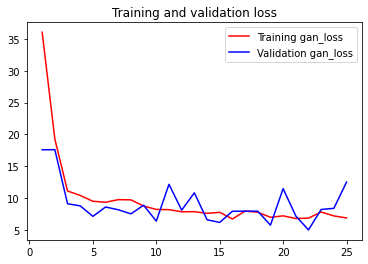

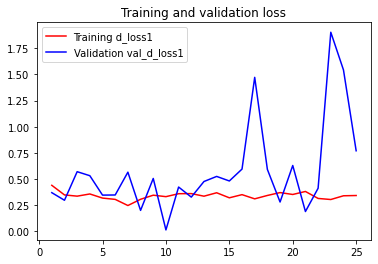

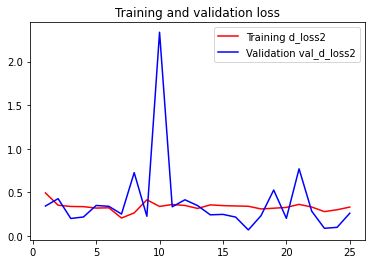

In [ ]:
index = 25
loss = history['g_loss'][:index]
val_loss = history['val_g_loss'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training gan_loss')
plt.plot(epochs, val_loss, 'b', label='Validation gan_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss1'][:index]
val_loss = history['val_d_loss1'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss1')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss1')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss2'][:index]
val_loss = history['val_d_loss2'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss2')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss2')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
name = "0090-GAN-0055-500"
save = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/'
d_model.save(save + "d-"+ name, include_optimizer=True)
g_model.save(save + "g-"+ name, include_optimizer=True)
gan_model.save(save + "gan-" + name, include_optimizer=True)

import json
with open(save + name + ".json", "w") as outfile:
    json.dump(history, outfile)

from tensorflow import keras
from tensorflow.keras.utils import save_img

for i in range(6): 
  a,b = next(preprocess(mini_test_gen))
  p = g_model.predict(a)
  #plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  #plt.imshow(p[0])
  #plt.show()
  save_img(save +   'images0090/' + name + '-' + str(i) + ".jpg", p[0])
  #

1/1 [==============================] - 0s 25ms/step


In [ ]:
train(d_model, g_model, gan_model, preprocess(train_gen), preprocess(validation_gen), n_batch = batch_size,n_steps = 500, n_validation = 20, n_patch = (64, 48), index = 25)

25
1/1 [==============================] - 0s 192ms/step - loss: 9.4437 - model_2_loss: 3.8642 - generator_loss: 0.0697
26
1/1 [==============================] - 0s 192ms/step - loss: 8.0073 - model_2_loss: 0.7993 - generator_loss: 0.0901
27
1/1 [==============================] - 0s 232ms/step - loss: 7.2245 - model_2_loss: 0.5022 - generator_loss: 0.0840
28
1/1 [==============================] - 0s 197ms/step - loss: 6.2607 - model_2_loss: 1.2813 - generator_loss: 0.0622
29
1/1 [==============================] - 0s 213ms/step - loss: 7.3306 - model_2_loss: 0.4427 - generator_loss: 0.0861
30
1/1 [==============================] - 0s 240ms/step - loss: 5.8243 - model_2_loss: 1.2702 - generator_loss: 0.0569
31
1/1 [==============================] - 0s 204ms/step - loss: 7.3000 - model_2_loss: 0.6818 - generator_loss: 0.0827
32
1/1 [==============================] - 0s 203ms/step - loss: 7.0383 - model_2_loss: 0.6000 - generator_loss: 0.0805
33
1/1 [==============================] - 0s 227

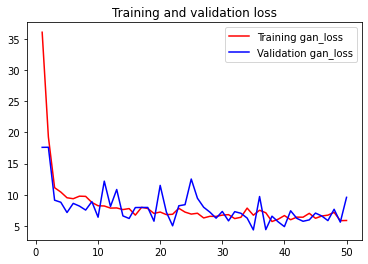

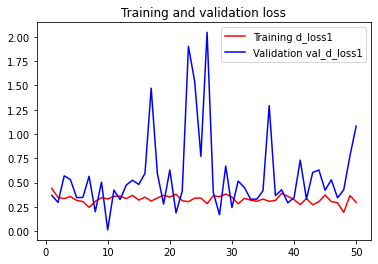

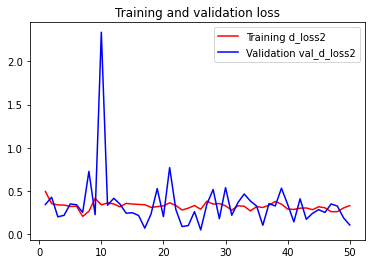

In [ ]:
index = 50
loss = history['g_loss'][:index]
val_loss = history['val_g_loss'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training gan_loss')
plt.plot(epochs, val_loss, 'b', label='Validation gan_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss1'][:index]
val_loss = history['val_d_loss1'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss1')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss1')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss2'][:index]
val_loss = history['val_d_loss2'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss2')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss2')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
name = "0090-GAN-0055-1000"
save = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/'
d_model.save(save + "d-"+ name, include_optimizer=True)
g_model.save(save + "g-"+ name, include_optimizer=True)
gan_model.save(save + "gan-" + name, include_optimizer=True)

import json
with open(save + name + ".json", "w") as outfile:
    json.dump(history, outfile)

from tensorflow import keras
from tensorflow.keras.utils import save_img

for i in range(6): 
  a,b = next(preprocess(mini_test_gen))
  p = g_model.predict(a)
  #plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  #plt.imshow(p[0])
  #plt.show()
  save_img(save +   'images0090/' + name + '-' + str(i) + ".jpg", p[0])
  #

1/1 [==============================] - 0s 23ms/step


In [ ]:
train(d_model, g_model, gan_model, preprocess(train_gen), preprocess(validation_gen), n_batch = batch_size,n_steps = 500, n_validation = 20, n_patch = (64, 48), index = 50)

50
1/1 [==============================] - 0s 191ms/step - loss: 8.9553 - model_2_loss: 1.0477 - generator_loss: 0.0988
51
1/1 [==============================] - 0s 214ms/step - loss: 5.8214 - model_2_loss: 0.9709 - generator_loss: 0.0606
52
1/1 [==============================] - 0s 205ms/step - loss: 6.0887 - model_2_loss: 0.6911 - generator_loss: 0.0675
53
1/1 [==============================] - 0s 190ms/step - loss: 5.1042 - model_2_loss: 1.2482 - generator_loss: 0.0482
54
1/1 [==============================] - 0s 196ms/step - loss: 6.0374 - model_2_loss: 0.7735 - generator_loss: 0.0658
55
1/1 [==============================] - 0s 213ms/step - loss: 4.8629 - model_2_loss: 0.8859 - generator_loss: 0.0497
56
1/1 [==============================] - 0s 219ms/step - loss: 5.6627 - model_2_loss: 1.2185 - generator_loss: 0.0556
57
1/1 [==============================] - 0s 218ms/step - loss: 11.1760 - model_2_loss: 0.7931 - generator_loss: 0.1298
58
1/1 [==============================] - 0s 21

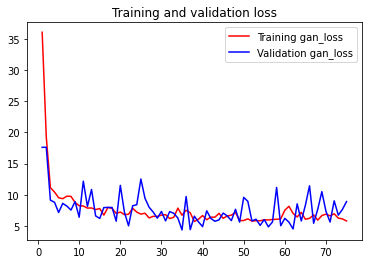

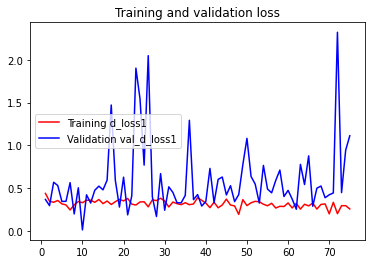

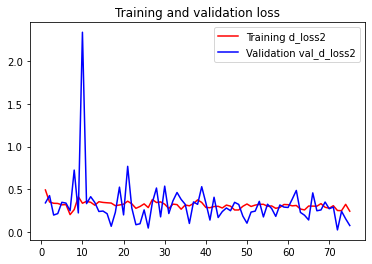

In [ ]:
index = 75
loss = history['g_loss'][:index]
val_loss = history['val_g_loss'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training gan_loss')
plt.plot(epochs, val_loss, 'b', label='Validation gan_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss1'][:index]
val_loss = history['val_d_loss1'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss1')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss1')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss2'][:index]
val_loss = history['val_d_loss2'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss2')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss2')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
name = "0090-GAN-0054-1500"
save = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/'
d_model.save(save + "d-"+ name, include_optimizer=True)
g_model.save(save + "g-"+ name, include_optimizer=True)
gan_model.save(save + "gan-" + name, include_optimizer=True)

import json
with open(save + name + ".json", "w") as outfile:
    json.dump(history, outfile)

from tensorflow import keras
from tensorflow.keras.utils import save_img

for i in range(6): 
  a,b = next(preprocess(mini_test_gen))
  p = g_model.predict(a)
  #plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  #plt.imshow(p[0])
  #plt.show()
  save_img(save +   'images0090/' + name + '-' + str(i) + ".jpg", p[0])
  #

1/1 [==============================] - 0s 39ms/step


In [ ]:
train(d_model, g_model, gan_model, preprocess(train_gen), preprocess(validation_gen), n_batch = batch_size,n_steps = 500, n_validation = 20, n_patch = (64, 48), index = 75)

75
1/1 [==============================] - 0s 204ms/step - loss: 5.8285 - model_2_loss: 0.7492 - generator_loss: 0.0635
76
1/1 [==============================] - 0s 200ms/step - loss: 5.9264 - model_2_loss: 0.3871 - generator_loss: 0.0692
77
1/1 [==============================] - 0s 236ms/step - loss: 8.0601 - model_2_loss: 1.1199 - generator_loss: 0.0868
78
1/1 [==============================] - 0s 191ms/step - loss: 5.7069 - model_2_loss: 0.4049 - generator_loss: 0.0663
79
1/1 [==============================] - 0s 193ms/step - loss: 7.3597 - model_2_loss: 1.0374 - generator_loss: 0.0790
80
1/1 [==============================] - 0s 193ms/step - loss: 4.6936 - model_2_loss: 1.2623 - generator_loss: 0.0429
81
1/1 [==============================] - 0s 193ms/step - loss: 7.7757 - model_2_loss: 1.4055 - generator_loss: 0.0796
82
1/1 [==============================] - 0s 207ms/step - loss: 6.7537 - model_2_loss: 1.2334 - generator_loss: 0.0690
83
1/1 [==============================] - 0s 256

In [ ]:
name = "0090-GAN-0055-2000"
save = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/'
d_model.save(save + "d-"+ name, include_optimizer=True)
g_model.save(save + "g-"+ name, include_optimizer=True)
gan_model.save(save + "gan-" + name, include_optimizer=True)

import json
with open(save + name + ".json", "w") as outfile:
    json.dump(history, outfile)

from tensorflow import keras
from tensorflow.keras.utils import save_img

for i in range(6): 
  a,b = next(preprocess(mini_test_gen))
  p = g_model.predict(a)
  #plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  #plt.imshow(p[0])
  #plt.show()
  save_img(save +   'images0090/' + name + '-' + str(i) + ".jpg", p[0])
  #

1/1 [==============================] - 0s 32ms/step


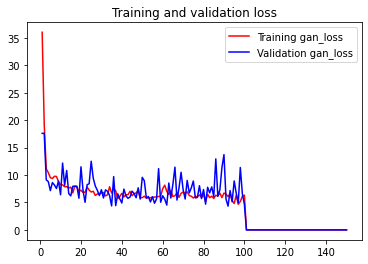

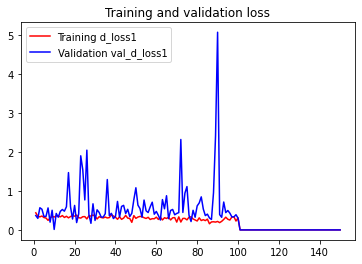

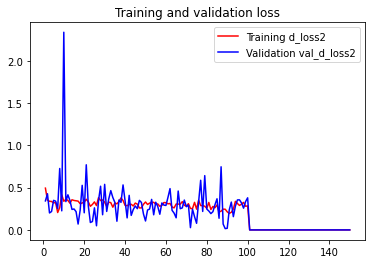

In [ ]:
index = 150
loss = history['g_loss'][:index]
val_loss = history['val_g_loss'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training gan_loss')
plt.plot(epochs, val_loss, 'b', label='Validation gan_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss1'][:index]
val_loss = history['val_d_loss1'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss1')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss1')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss2'][:index]
val_loss = history['val_d_loss2'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss2')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss2')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
train(d_model, g_model, gan_model, preprocess(train_gen), preprocess(validation_gen), n_batch = batch_size,n_steps = 2000, n_validation = 20, n_patch = (64, 48), index = 100)

100
1/1 [==============================] - 0s 212ms/step - loss: 4.9860 - model_2_loss: 0.7227 - generator_loss: 0.0533
101
1/1 [==============================] - 0s 214ms/step - loss: 6.3326 - model_2_loss: 0.7025 - generator_loss: 0.0704
102
1/1 [==============================] - 0s 202ms/step - loss: 4.9982 - model_2_loss: 0.6643 - generator_loss: 0.0542
103
1/1 [==============================] - 0s 197ms/step - loss: 6.9259 - model_2_loss: 0.9468 - generator_loss: 0.0747
104
1/1 [==============================] - 0s 190ms/step - loss: 12.5722 - model_2_loss: 1.3357 - generator_loss: 0.1405
105
1/1 [==============================] - 0s 199ms/step - loss: 3.2713 - model_2_loss: 0.4873 - generator_loss: 0.0348
106
1/1 [==============================] - 0s 190ms/step - loss: 6.6631 - model_2_loss: 0.7457 - generator_loss: 0.0740
107
1/1 [==============================] - 0s 195ms/step - loss: 6.0062 - model_2_loss: 0.6569 - generator_loss: 0.0669
108
1/1 [==============================

In [ ]:
name = "0090-GAN-0055-4000"
save = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/'
d_model.save(save + "d-"+ name, include_optimizer=True)
g_model.save(save + "g-"+ name, include_optimizer=True)
gan_model.save(save + "gan-" + name, include_optimizer=True)

import json
with open(save + name + ".json", "w") as outfile:
    json.dump(history, outfile)

from tensorflow import keras
from tensorflow.keras.utils import save_img

for i in range(6): 
  a,b = next(preprocess(mini_test_gen))
  p = g_model.predict(a)
  #plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  #plt.imshow(p[0])
  #plt.show()
  save_img(save +   'images0090/' + name + '-' + str(i) + ".jpg", p[0])
  #

1/1 [==============================] - 0s 31ms/step


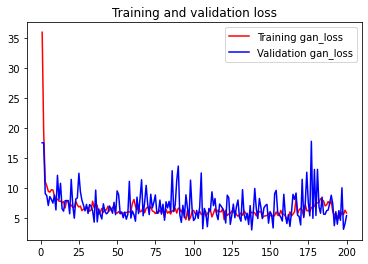

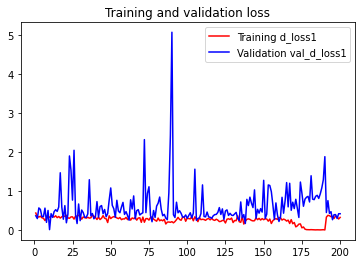

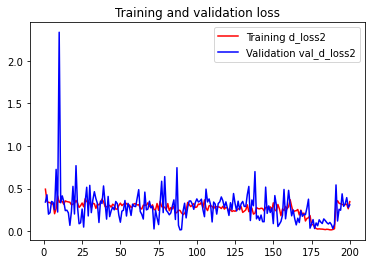

In [ ]:
index = 200
loss = history['g_loss'][:index]
val_loss = history['val_g_loss'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training gan_loss')
plt.plot(epochs, val_loss, 'b', label='Validation gan_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss1'][:index]
val_loss = history['val_d_loss1'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss1')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss1')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss2'][:index]
val_loss = history['val_d_loss2'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss2')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss2')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
opt = Adam(learning_rate=0.0002, beta_1=0.5)
gan_model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,120])

In [ ]:
train(d_model, g_model, gan_model, preprocess(train_gen), preprocess(validation_gen), n_batch = batch_size,n_steps = 2000, n_validation = 20, n_patch = (64, 48), index = 200)

200
1/1 [==============================] - 0s 198ms/step - loss: 5.7703 - model_2_loss: 1.0569 - generator_loss: 0.0393
201
1/1 [==============================] - 0s 196ms/step - loss: 8.8019 - model_2_loss: 0.8689 - generator_loss: 0.0661
202
1/1 [==============================] - 0s 199ms/step - loss: 7.1057 - model_2_loss: 0.6903 - generator_loss: 0.0535
203
1/1 [==============================] - 0s 207ms/step - loss: 6.6909 - model_2_loss: 0.9989 - generator_loss: 0.0474
204
1/1 [==============================] - 0s 200ms/step - loss: 9.7650 - model_2_loss: 2.3462 - generator_loss: 0.0618
205
1/1 [==============================] - 0s 190ms/step - loss: 4.9863 - model_2_loss: 0.9686 - generator_loss: 0.0335
206
1/1 [==============================] - 0s 192ms/step - loss: 14.2009 - model_2_loss: 3.3753 - generator_loss: 0.0902
207
1/1 [==============================] - 0s 189ms/step - loss: 8.7523 - model_2_loss: 3.5681 - generator_loss: 0.0432
208
1/1 [==============================

In [ ]:
name = "0090-GAN-0055-6000"
save = r'/content/drive/MyDrive/Uni/Cuarto curso/Primer cuatrimestre/TFG/WebScrapping/'
d_model.save(save + "d-"+ name, include_optimizer=True)
g_model.save(save + "g-"+ name, include_optimizer=True)
gan_model.save(save + "gan-" + name, include_optimizer=True)

import json
with open(save + name + ".json", "w") as outfile:
    json.dump(history, outfile)

from tensorflow import keras
from tensorflow.keras.utils import save_img

for i in range(6): 
  a,b = next(preprocess(mini_test_gen))
  p = g_model.predict(a)
  #plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  #plt.imshow(p[0])
  #plt.show()
  save_img(save +   'images0090/' + name + '-' + str(i) + ".jpg", p[0])
  #

1/1 [==============================] - 0s 27ms/step


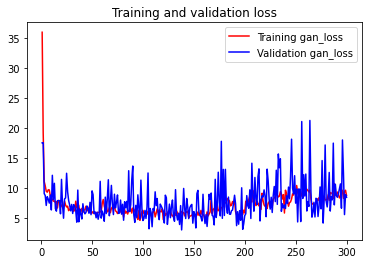

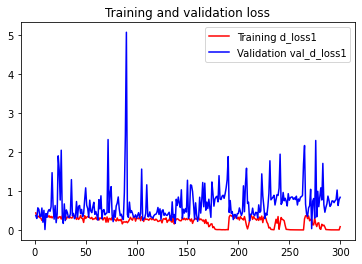

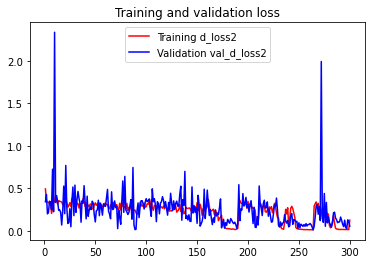

In [ ]:
index = 300
loss = history['g_loss'][:index]
val_loss = history['val_g_loss'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training gan_loss')
plt.plot(epochs, val_loss, 'b', label='Validation gan_loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss1'][:index]
val_loss = history['val_d_loss1'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss1')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss1')
plt.title('Training and validation loss')
plt.legend()
plt.show()

loss = history['d_loss2'][:index]
val_loss = history['val_d_loss2'][:index]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training d_loss2')
plt.plot(epochs, val_loss, 'b', label='Validation val_d_loss2')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
train(d_model, g_model, gan_model, preprocess(train_gen), preprocess(validation_gen), n_batch = batch_size,n_steps = 2000, n_validation = 20, n_patch = (64, 48), index = 300)

300
1/1 [==============================] - 0s 196ms/step - loss: 7.0484 - model_2_loss: 1.3728 - generator_loss: 0.0473
301
1/1 [==============================] - 0s 193ms/step - loss: 5.7866 - model_2_loss: 1.0033 - generator_loss: 0.0399
302
1/1 [==============================] - 0s 190ms/step - loss: 8.5915 - model_2_loss: 1.6742 - generator_loss: 0.0576
303
1/1 [==============================] - 0s 189ms/step - loss: 7.6686 - model_2_loss: 1.9888 - generator_loss: 0.0473
304
1/1 [==============================] - 0s 189ms/step - loss: 10.0914 - model_2_loss: 2.8096 - generator_loss: 0.0607
305
1/1 [==============================] - 0s 187ms/step - loss: 3.7513 - model_2_loss: 1.6712 - generator_loss: 0.0173
306
1/1 [==============================] - 0s 204ms/step - loss: 7.1007 - model_2_loss: 1.3990 - generator_loss: 0.0475
307
1/1 [==============================] - 0s 190ms/step - loss: 7.0984 - model_2_loss: 1.3256 - generator_loss: 0.0481
308
1/1 [==============================

In [ ]:

for i in range(6): 
  a,b = next(preprocess(test_gen))
  p = g_model.predict(a)

  plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  plt.imshow(b[0])
  plt.show()
  plt.figure(figsize=(img_height/96, img_width/96), dpi=96)
  plt.imshow(p[0])
  plt.show()
  #save_img(save +   'images0090/' + name + '-' + str(i) + ".jpg", p[0])
  #

Output hidden; open in https://colab.research.google.com to view.